In [1]:
# implementing a vgg block

import torch
import torch.nn as nn

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [2]:
# implementing VGG11

conv_arch = ((1,64), (1,128), (2,256), (2,512), (2,512))

In [3]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels=out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(), 
        nn.Linear(in_channels *7 *7, 4096), nn.ReLU(), nn.Dropout(p=0.5), 
        nn.Linear(4096, 4096),nn.ReLU(), nn.Dropout(p=0.5),
        nn.Linear(4096, 10)
    )

In [4]:
vgg_net = vgg(conv_arch)

In [5]:
X = torch.randn(1,1,224,224)

def look_at_net(net, X):
    out = X
    for layer in net:
        out = layer(out)
        print(f'For {layer.__class__.__name__}: {out.shape}')
        
look_at_net(vgg_net, X)

For Sequential: torch.Size([1, 64, 112, 112])
For Sequential: torch.Size([1, 128, 56, 56])
For Sequential: torch.Size([1, 256, 28, 28])
For Sequential: torch.Size([1, 512, 14, 14])
For Sequential: torch.Size([1, 512, 7, 7])
For Flatten: torch.Size([1, 25088])
For Linear: torch.Size([1, 4096])
For ReLU: torch.Size([1, 4096])
For Dropout: torch.Size([1, 4096])
For Linear: torch.Size([1, 4096])
For ReLU: torch.Size([1, 4096])
For Dropout: torch.Size([1, 4096])
For Linear: torch.Size([1, 10])


z:\installs\anconda\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [6]:
# we reduce the ratio as it is very computationaly expensive to traina VGG model
ratio = 4
small_conv_arch = [(pair[0], pair[1]//ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

look_at_net(net, X)

For Sequential: torch.Size([1, 16, 112, 112])
For Sequential: torch.Size([1, 32, 56, 56])
For Sequential: torch.Size([1, 64, 28, 28])
For Sequential: torch.Size([1, 128, 14, 14])
For Sequential: torch.Size([1, 128, 7, 7])
For Flatten: torch.Size([1, 6272])
For Linear: torch.Size([1, 4096])
For ReLU: torch.Size([1, 4096])
For Dropout: torch.Size([1, 4096])
For Linear: torch.Size([1, 4096])
For ReLU: torch.Size([1, 4096])
For Dropout: torch.Size([1, 4096])
For Linear: torch.Size([1, 10])


In [7]:
lr, num_epochs, batch_size = 0.01, 20, 128

In [8]:

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets


my_transforms = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum=0.9)

In [10]:
def accuracy(y_hat,y):
    return (y_hat.argmax(1)==y).sum()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
def full_accuracy(net, data_iter):
    net.eval()
#     device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'
    net = net.to(device)
    
    total_acc = 0
    total_num = 0
    with torch.no_grad():
        for X, y in data_iter:
            X = X.to(device)
            y = y.to(device)

            y_hat = net(X)

            total_acc += accuracy(y_hat, y)
            total_num += y.numel()
    
    return total_acc/total_num

In [13]:
def train_net(net): 
    train_loss = []
    train_acc = []
    test_acc = []

    net= net.to(device)
    for epoch in range(num_epochs):

        acc_value = 0
        total_number = 0
        total_loss= 0
        for i, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            total_loss += loss.item()
            acc_value += accuracy(outputs, labels)
            total_number += labels.numel()

        with torch.no_grad():

            print(f"\tEpoch {epoch} : Statistics: ")
            print(f'\tcurrent train loss : {total_loss} / {total_number} : {float(total_loss/total_number)}')
            print(f'\tcurrent train acc : {acc_value}/{total_number} : {float(acc_value/total_number)}')
            print(f'\tcurrent test acc : {float(full_accuracy(net, test_dataloader))}')


            train_loss.append(float(total_loss/total_number))
            test_acc.append(float(full_accuracy(net, test_dataloader)))
            train_acc.append(float(acc_value/total_number))
    
    return train_loss, test_acc, train_acc

In [14]:
for X, y in train_dataloader:
    print(X.shape, len(y))
    look_at_net(net.to(device), X.to(device).float())
    break

torch.Size([128, 1, 224, 224]) 128
For Sequential: torch.Size([128, 16, 112, 112])
For Sequential: torch.Size([128, 32, 56, 56])
For Sequential: torch.Size([128, 64, 28, 28])
For Sequential: torch.Size([128, 128, 14, 14])
For Sequential: torch.Size([128, 128, 7, 7])
For Flatten: torch.Size([128, 6272])
For Linear: torch.Size([128, 4096])
For ReLU: torch.Size([128, 4096])
For Dropout: torch.Size([128, 4096])
For Linear: torch.Size([128, 4096])
For ReLU: torch.Size([128, 4096])
For Dropout: torch.Size([128, 4096])
For Linear: torch.Size([128, 10])


In [15]:
try:
    train_loss, test_acc, train_acc = train_net(net)
except Exception as e:
    print(e)

CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 4.00 GiB total capacity; 2.69 GiB already allocated; 15.23 MiB free; 2.70 GiB reserved in total by PyTorch)


In [16]:
# its difficult to train so
# 1. lets reduce the image size
# 2. and also create a smaller architecture
my_transforms = transforms.Compose(
                [
#                     transforms.Resize(224),
                    transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [17]:
# So it is difficult to run this lets reduce the model even further

new_conv_arch = ((1,64), (1, 128))

In [18]:
def vgg_reduced(conv_arch):
    conv_blks = []
    in_channels = 1
    
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels=out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(), 
        nn.Linear(in_channels *7 *7, 4096), nn.ReLU(), nn.Dropout(p=0.5), 
        nn.Linear(4096, 10)
    )

In [19]:
X = torch.randn(1,1,28,28)

net = vgg_reduced(new_conv_arch)

look_at_net(net, X)

For Sequential: torch.Size([1, 64, 14, 14])
For Sequential: torch.Size([1, 128, 7, 7])
For Flatten: torch.Size([1, 6272])
For Linear: torch.Size([1, 4096])
For ReLU: torch.Size([1, 4096])
For Dropout: torch.Size([1, 4096])
For Linear: torch.Size([1, 10])


In [20]:
try:
    lr = 0.1
    num_epochs=2
    train_loss, test_acc, train_acc = train_net(net)
except Exception as e:
    print(e)

	Epoch 0 : Statistics: 
	current train loss : 1080.0545313358307 / 60000 : 0.01800090885559718
	current train acc : 5439/60000 : 0.09064999967813492
	current test acc : 0.09959999471902847
	Epoch 1 : Statistics: 
	current train loss : 1079.7904839515686 / 60000 : 0.017996508065859475
	current train acc : 5976/60000 : 0.09960000216960907
	current test acc : 0.09959999471902847


finished


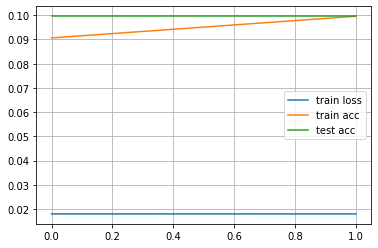

In [21]:
print("finished")

import matplotlib.pyplot as plt
num_epochs = num_epochs
plt.plot(range(num_epochs), train_loss, label='train loss')
plt.plot(range(num_epochs), train_acc, label = 'train acc')
plt.plot(range(num_epochs), test_acc, label = 'test acc')
plt.grid(True)
plt.legend()
plt.show()

## Training predefined VGG

In [22]:
my_transforms = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.ToTensor()]
)

train_dataset = datasets.FashionMNIST(download=False,root="../data", train=True, transform=my_transforms)
test_dataset = datasets.FashionMNIST(download=False, root="../data", train=False, transform=my_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [23]:
import os
import torchvision

# Suppose you are trying to load pre-trained resnet model in directory- models\resnet

os.environ['TORCH_HOME'] = '../models' #setting the environment variable


In [24]:
vgg_predefined = torchvision.models.vgg16(pretrained=True) 

In [25]:
for param in vgg_predefined.features.parameters(): # only freezing convolutional weights
    param.requires_grad = False

In [26]:
vgg_predefined

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
vgg_predefined.features[0] 

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [28]:
vgg_predefined.features[0] = nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1))

In [29]:
vgg_predefined.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

In [30]:
optimizer = torch.optim.SGD(vgg_predefined.parameters(), lr=0.001, momentum=0.9)
loss_criterion = nn.CrossEntropyLoss()

In [31]:
try:
    lr = 0.05
    num_epochs=4
    train_loss, test_acc, train_acc = train_net(vgg_predefined)
except Exception as e:
    print(e)


CUDA out of memory. Tried to allocate 1.53 GiB (GPU 0; 4.00 GiB total capacity; 2.25 GiB already allocated; 423.23 MiB free; 2.30 GiB reserved in total by PyTorch)


### Exercises

1. When printing out the dimensions of the layers we only saw 8 results rather than 11. Where
did the remaining 3 layer information go?

* in maxpool

2. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs
more GPU memory. Analyze the reasons for this.

* it has more conv layers

3. Try changing the height and width of the images in Fashion-MNIST from 224 to 96. What
influence does this have on the experiments?

* it willrun faster

4. Refer to Table 1 in the VGG paper (Simonyan & Zisserman, 2014) to construct other common
models, such as VGG-16 or VGG-19.

* it can be done but my GPU says hi